In [1]:
import os
import glob
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_rel

In [2]:
def create_df_for_descr_ind_avg(max_arrays: int) -> pd.DataFrame:
    """Reads the data for all subjects and from both the individual and the average approach.
    It selects the array that is specified in max_arrays, if it exists. 
    
    Parameters
    ----------
    max_arrays : int
        The maximum number of arrays to read.
    
    Returns
    -------
    out_df : pd.DataFrame
        A dataframe used for descriptive stats:
        ["subject", "method", "hemisphere", "array", "total_dice", "prop_total_dice", 
        "array_yield", "total_HD", "prop_total_hd", "cost", "prop_cost"]
    """
    methods = ["ind", "avg"]
    
    ind_path = "/home/odysseas/Desktop/UU/thesis/BayesianOpt/5_arrays_10x10x10/results/"
    avg_path = "/home/odysseas/Desktop/UU/thesis/BayesianOpt/fsaverage_5_arrays_10x10x10/results/"
    results_paths = [ind_path, avg_path]
    
    ind_subs = os.listdir(ind_path)
    avg_subs = os.listdir(avg_path)
    subs_lists = [ind_subs, avg_subs]
    out_df = pd.DataFrame()
    arrays = [i for i in range(1, max_arrays + 1)]
    for sub_list, sub_path, method in zip(subs_lists, results_paths, methods):
        if "exp" in sub_list:
            sub_list.remove("exp")
        if "fsaverage" in sub_list:
            sub_list.remove("fsaverage")
        for sub in sub_list:
            for hem in ["LH", "RH"]:
                hem_dir = os.path.join(sub_path, sub, hem)
                filenames = glob.glob(os.path.join(hem_dir, "*.csv"))
                # Assuming there's only one file in the directory, you can take the first one
                filename = [file for file in filenames if "best" in file][0]
                
                res_df = pd.read_csv(filename)        
                columns_to_select = ["array", "total_dice", "prop_total_dice", "array_yield", "total_HD", "prop_total_hd", "cost", "prop_cost"]
                
                max_array_exists = arrays[-1] in res_df["array"].tolist()
                if max_array_exists:
                    for array in arrays:
                        arr_row = res_df[res_df["array"] == array]
                        selected_columns = arr_row[columns_to_select].copy()
                        selected_columns["subject"] = sub
                        selected_columns["hemisphere"] = hem
                        selected_columns["method"] = method
                        column_order = ["subject", "method", "hemisphere", "array", "total_dice", "prop_total_dice", "array_yield", "total_HD", "prop_total_hd", "cost", "prop_cost"]
                        selected_columns = selected_columns[column_order]
                        out_df = pd.concat([out_df, selected_columns], ignore_index=True)
    return out_df

def create_df_for_ind_vs_avg() -> pd.DataFrame:
    """Reads the data for all subjects and from both the individual and the average approach.
    It selects the last array placed, regardless of its number or whether the same array
    was placed in the other hemisphere as well. 
    So in total it has (subs x hems x methods) = (181 x 2 x 2) = 724 rows
    
    Returns
    -------
    out_df : pd.DataFrame
        A dataframe to be put in the AnovaRM function with columns:
        ["subject", "hemisphere", "method", "max_array", "total_dice", "prop_total_dice", 
        "array_yield", "total_HD", "prop_total_hd", "cost", "prop_cost"]
    """
    methods = ["ind", "avg"]
    
    ind_path = "/home/odysseas/Desktop/UU/thesis/BayesianOpt/5_arrays_10x10x10/results/"
    avg_path = "/home/odysseas/Desktop/UU/thesis/BayesianOpt/fsaverage_5_arrays_10x10x10/results/"
    results_paths = [ind_path, avg_path]
    
    ind_subs = os.listdir(ind_path)
    avg_subs = os.listdir(avg_path)
    subs_lists = [ind_subs, avg_subs]
    out_df = pd.DataFrame()
    
    for sub_list, sub_path, method in zip(subs_lists, results_paths, methods):
        if "exp" in sub_list:
            sub_list.remove("exp")
        if "fsaverage" in sub_list:
            sub_list.remove("fsaverage")
    
        for sub in sub_list:
            for hem in ["LH", "RH"]:
                hem_dir = os.path.join(sub_path, sub, hem)
                filenames = glob.glob(os.path.join(hem_dir, "*.csv"))
                # Assuming there's only one file in the directory, you can take the first one
                filename = [file for file in filenames if "best" in file][0]
                try:
                    res_df = pd.read_csv(filename)
                    res_df = res_df.iloc[-1:]    # select max array (the last row)
            
                    columns_to_select = ["array", "total_dice", "prop_total_dice", "array_yield", "total_HD", "prop_total_hd", "cost", "prop_cost"]
                    selected_columns = res_df[columns_to_select].copy()
                    selected_columns["subject"] = sub
                    selected_columns["hemisphere"] = hem
                    selected_columns["method"] = method
                    column_order = ["subject", "hemisphere", "method", "array", "total_dice", "prop_total_dice", "array_yield", "total_HD", "prop_total_hd", "cost", "prop_cost"]
                    selected_columns = selected_columns[column_order]
                    out_df = pd.concat([out_df, selected_columns], ignore_index=True)
                except FileNotFoundError as e:
                    print(f"File {filename} not found")
                    continue
    out_df.rename(columns={"array": "max_array"}, inplace=True)
    return out_df

In [74]:
def violin_plots_all(results_df: pd.DataFrame) -> None:
    """Creates violin plots for the cost function, given the df from create_df_for_ind_vs_avg().
    This df considers all 181 subjects from both hemispheres and methods and contains
    the last validly placed array."""
    total_observations = len(results_df.subject.unique())
    res_df = results_df.copy()
    res_df["total_dice_loss"] = 1 - res_df["total_dice"]
    res_df["array_yield_loss"] = 1 - res_df["array_yield"]
    dvs = ["cost", "total_dice_loss", "array_yield_loss", "total_HD"]
    dv_names = ["Cost", "Dice loss (1-dice)", "Yield loss (1-yield)", "Hellinger distance"]
    # yield is not meaningful because it's only for the last validly placed array
    dvs.remove("array_yield_loss")
    dv_names.remove("Yield loss (1-yield)")
    fig, axes = plt.subplots(nrows=1, ncols=len(dvs), figsize=(16, 8), sharex=True)
    for i, dv in enumerate(dvs):
        sns.violinplot(data=res_df, x="method", y=dv, hue="hemisphere", inner="box", split=True, ax=axes[i], order=["ind", "avg"])
        axes[i].legend(title="hemisphere", labels=["LH", "RH"], handles=axes[i].legend_.legend_handles)
        axes[i].set_title(f"{dv_names[i]} per method", fontsize=16)
        axes[i].set_xlabel("", fontsize=16)
        axes[i].set_ylabel(dv_names[i], fontsize=16)
        axes[i].tick_params(axis="x", labelsize=16)
    fig.suptitle(f"Mean losses per method (based on the last validly placed array) for all {total_observations} subjects", fontsize=24)
    fig.supxlabel("Method", fontsize=20)
    plt.tight_layout()
    plt.savefig("./losses_violin_plots.png")
    plt.show()
    

def visualize_yield_loss(ind_descriptives: pd.DataFrame, avg_descriptives: pd.DataFrame) -> None:
    """Creates and saves a plot for the yield loss."""
    ind_descriptives["method"] = ["ind"] * len(ind_descriptives)
    avg_descriptives["method"] = ["avg"] * len(avg_descriptives)
    df = pd.concat([ind_descriptives, avg_descriptives], ignore_index=True, axis=0)

    g = sns.catplot(data=df, x="method", y="array_yield_loss", hue="hemisphere", 
                    col="array", kind="bar", errorbar="sd", sharex=True, legend=False)
    plt.suptitle("Mean yield loss per method, array, and hemisphere", fontsize=28)
    plt.subplots_adjust(top=0.8)
    i = 0
    for ax, col in zip(g.axes.flatten(), df["array"].unique()):
        ax.set_ylabel("Array yield loss", fontsize=24)
        ax.set_xlabel("")
        if i == 2:
            ax.set_xlabel("Method", fontsize=24)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=20)
        ax.set_title(f"array {col}", fontsize=20)
        i += 1

    plt.legend(bbox_to_anchor=(1, 1.35), loc="upper right", title="hemisphere",borderaxespad=0., frameon=False, fontsize="xx-large", title_fontsize="xx-large")
    plt.savefig("./yield_losses_exp2.png")
    plt.show()
    

def create_histograms(data: pd.DataFrame) -> None:
    """Creates and saves histograms of the cost function by hemisphere and method.
    
    Parameters
    ----------
    data : pd.DataFrame
        The dataframe generated by create_df_for_ind_vs_avg()
    """
    data_LH = data[data.hemisphere == "LH"]
    data_RH = data[data.hemisphere == "RH"]
    row = 0
    col = 0
    colors = ["green", "skyblue"]
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    for hem, df in zip(["left", "right"], [data_LH, data_RH]):
        for method, method_name in zip(["ind", "avg"], ["individual", "average"]):
            method_df = df[df["method"] == method].reset_index(drop=True).copy()
            sns.histplot(data=method_df, x="cost", kde=False, color=colors[col], ax=axes[row, col])
            axes[row, col].set_xlabel(f"Cost for {method_name} method", fontsize=14) if row == 1 else axes[row, col].set_xlabel("")
            axes[row, col].set_ylabel("")
            col += 1
        row += 1
        col = 0
    
    labels = ["Count for left hemisphere", "Count for right hemisphere"]
    for l, ax in zip(labels, axes):
        ax[0].set_ylabel(l, fontsize=14)
        
    fig.suptitle(f"Distribution of cost per method and hemisphere", fontsize=24)
    plt.tight_layout()
    plt.savefig(f"./histograms_exp2.png")
    plt.show()

def get_descriptive_stats(all_arrays_df: list, method: str, hem: str) -> pd.DataFrame:
    """Gets descriptive statistics for the given methodology and hemisphere.
    
    Parameters
    ----------
    all_arrays_df : list
        A list with all dataframes (one dataframe for each max array considered).
        The dataframes are created using create_df_for_descr_ind_avg(max_arrays).
    method : str
        The methodology, one of "ind", "avg"
    hem : str
        The hemisphere, one of "LH", "RH"
    
    Returns
    -------
    descriptive_stats_df : pd.DataFrame
        A dataframe with descriptive statistics for the given method and hemisphere, one row for each array.
        So it describes how many subs completed that array, with the average values.
    """
    descriptive_stats_df = pd.DataFrame()
    for df in all_arrays_df:
        method_hem_df = df[(df.method == method) & (df.hemisphere == hem)]
        max_array = method_hem_df.array.max()
        total_subs = len(method_hem_df.subject.unique())
        stats = method_hem_df.groupby(["hemisphere", "array"])[
            ["total_dice", "prop_total_dice", "array_yield", "total_HD", "prop_total_hd", "cost",
             "prop_cost"]].mean().reset_index()
        stats = stats[stats["array"] == max_array].reset_index(drop=True)
        stats["total_subjects"] = total_subs
        stats["total_dice_loss"] = 1 - stats["total_dice"]
        stats["array_yield_loss"] = 1 - stats["array_yield"]
        column_order = ["array", "hemisphere", "total_subjects", "total_dice_loss", "prop_total_dice",
                        "array_yield_loss", "total_HD", "prop_total_hd", "cost", "prop_cost"]
        stats = stats[column_order]
        descriptive_stats_df = pd.concat([descriptive_stats_df, stats], ignore_index=True)

    return descriptive_stats_df

def get_mean_std(data: pd.DataFrame) -> None:
    """Prints the mean and standard deviation of the data by method and hemisphere.
    
    Parameters
    ----------
    data : pd.DataFrame
        The dataframe generated by create_df_for_ind_vs_avg()
    """
    data_LH = data[data.hemisphere == "LH"]
    data_RH = data[data.hemisphere == "RH"]
    ind_LH = data_LH[data_LH["method"] == "ind"]
    avg_LH = data_LH[data_LH["method"] == "avg"]
    ind_RH = data_RH[data_RH["method"] == "ind"]
    avg_RH = data_RH[data_RH["method"] == "avg"]
    all_dfs = [ind_LH, avg_LH, ind_RH, avg_RH]
    names = ["ind_LH", "avg_LH", "ind_RH", "avg_RH"]
    for name, df in zip(names, all_dfs):
        mean = df["cost"].mean()
        std = df["cost"].std()
        print(f"data: {name}, mean: {mean}, std: {std}")
        
def run_paired_ttest(data: pd.DataFrame, dv: str) -> None:
    """Runs and prints two paired samples t-tests. One for each hemisphere. 
    The within subjects factor is the methodology and the dv is the cost.
    The alternative hypothesis is one-sided: individual < average
    
    Parameters
    ----------
    data : pd.DataFrame
        The dataframe generated by create_df_for_ind_vs_avg()
    """
    data_LH = data[data.hemisphere == "LH"]
    data_RH = data[data.hemisphere == "RH"]
    ind_LH = data_LH[data_LH["method"] == "ind"]
    avg_LH = data_LH[data_LH["method"] == "avg"]
    ind_RH = data_RH[data_RH["method"] == "ind"]
    avg_RH = data_RH[data_RH["method"] == "avg"]
    print(ttest_rel(ind_LH[dv], avg_LH[dv], alternative="less"))
    print(ttest_rel(ind_RH[dv], avg_RH[dv], alternative="less"))

In [5]:
ind_avg_hem_arr1 = create_df_for_descr_ind_avg(max_arrays=1)
ind_avg_hem_arr2 = create_df_for_descr_ind_avg(max_arrays=2)
ind_avg_hem_arr3 = create_df_for_descr_ind_avg(max_arrays=3)
ind_avg_hem_arr4 = create_df_for_descr_ind_avg(max_arrays=4)
ind_avg_hem_arr5 = create_df_for_descr_ind_avg(max_arrays=5)
ind_avg_list_all_array_dfs = [ind_avg_hem_arr1, ind_avg_hem_arr2, ind_avg_hem_arr3, ind_avg_hem_arr4, ind_avg_hem_arr5]

In [25]:
ind_avg_hem_arr5.head()

,subject,method,hemisphere,array,total_dice,prop_total_dice,array_yield,total_HD,prop_total_hd,cost,prop_cost
0,114823,ind,LH,1,0.191435,0.245009,0.609,0.850841,0.436150,2.628956,0.237749
1,114823,ind,LH,2,0.221360,0.283309,0.561,0.841391,0.463785,2.591980,0.261442
2,114823,ind,LH,3,0.222758,0.285098,0.296,0.840785,0.465556,2.603227,0.254236
3,114823,ind,LH,4,0.223341,0.285844,0.288,0.840519,0.466333,2.602778,0.254523
4,114823,ind,LH,5,0.232503,0.297570,0.327,0.835550,0.480864,2.586696,0.264828


In [38]:
ind_avg_list_all_array_dfs[0].head()

,subject,method,hemisphere,array,total_dice,prop_total_dice,array_yield,total_HD,prop_total_hd,cost,prop_cost
0,114823,ind,LH,1,0.191435,0.245009,0.609,0.850841,0.436150,2.628956,0.237749
1,114823,ind,RH,1,0.601614,0.694429,0.588,0.691783,0.714592,2.060769,0.600157
2,200311,ind,LH,1,0.283553,0.373494,0.441,0.826635,0.567088,2.521032,0.309707
3,200311,ind,RH,1,0.471554,0.593022,0.421,0.762771,0.685638,2.270167,0.470609
4,146129,ind,LH,1,0.239636,0.329377,0.531,0.841694,0.532326,2.575508,0.270404


In [38]:
ind_descriptives_LH = get_descriptive_stats(ind_avg_list_all_array_dfs, "ind", "LH")
ind_descriptives_RH = get_descriptive_stats(ind_avg_list_all_array_dfs, "ind", "RH")
avg_descriptives_LH = get_descriptive_stats(ind_avg_list_all_array_dfs, "avg", "LH")
avg_descriptives_RH = get_descriptive_stats(ind_avg_list_all_array_dfs, "avg", "RH")
ind_descriptives = pd.concat([ind_descriptives_LH, ind_descriptives_RH], axis=0)
avg_descriptives = pd.concat([avg_descriptives_LH, avg_descriptives_RH], axis=0)

In [10]:
avg_descriptives_LH

,array,hemisphere,total_subjects,total_dice_loss,prop_total_dice,array_yield_loss,total_HD,prop_total_hd,cost,prop_cost
0,1,LH,181,0.826225,0.236645,0.516906,0.870982,0.418716,2.673053,0.208140
1,2,LH,181,0.811272,0.256649,0.626470,0.864685,0.438526,2.657281,0.218209
2,3,LH,158,0.792749,0.281484,0.576677,0.860662,0.450194,2.632245,0.234149
3,4,LH,76,0.770149,0.309026,0.668118,0.848732,0.476938,2.602286,0.253237
4,5,LH,19,0.735994,0.350922,0.520526,0.836763,0.505816,2.548783,0.288232


In [11]:
avg_descriptives_RH

,array,hemisphere,total_subjects,total_dice_loss,prop_total_dice,array_yield_loss,total_HD,prop_total_hd,cost,prop_cost
0,1,RH,181,0.704533,0.366084,0.575845,0.822563,0.488779,2.505888,0.317294
1,2,RH,165,0.662040,0.418750,0.678182,0.805180,0.536703,2.451129,0.352400
2,3,RH,145,0.639615,0.446148,0.603814,0.795140,0.563726,2.414945,0.375763
3,4,RH,87,0.634688,0.448354,0.529736,0.793275,0.558921,2.404450,0.382660
4,5,RH,14,0.644928,0.431898,0.544643,0.796061,0.548020,2.418222,0.374722


In [4]:
data = create_df_for_ind_vs_avg()

In [13]:
data.groupby(["method", "hemisphere", "max_array"])[["subject"]].count()

subject
method hemisphere max_array         
avg    LH         2               23
                  3               82
                  4               57
                  5               19
       RH         1               16
                  2               20
                  3               58
                  4               73
                  5               14
ind    LH         3               17
                  4               48
                  5              116
       RH         3               11
                  4               64
                  5              106

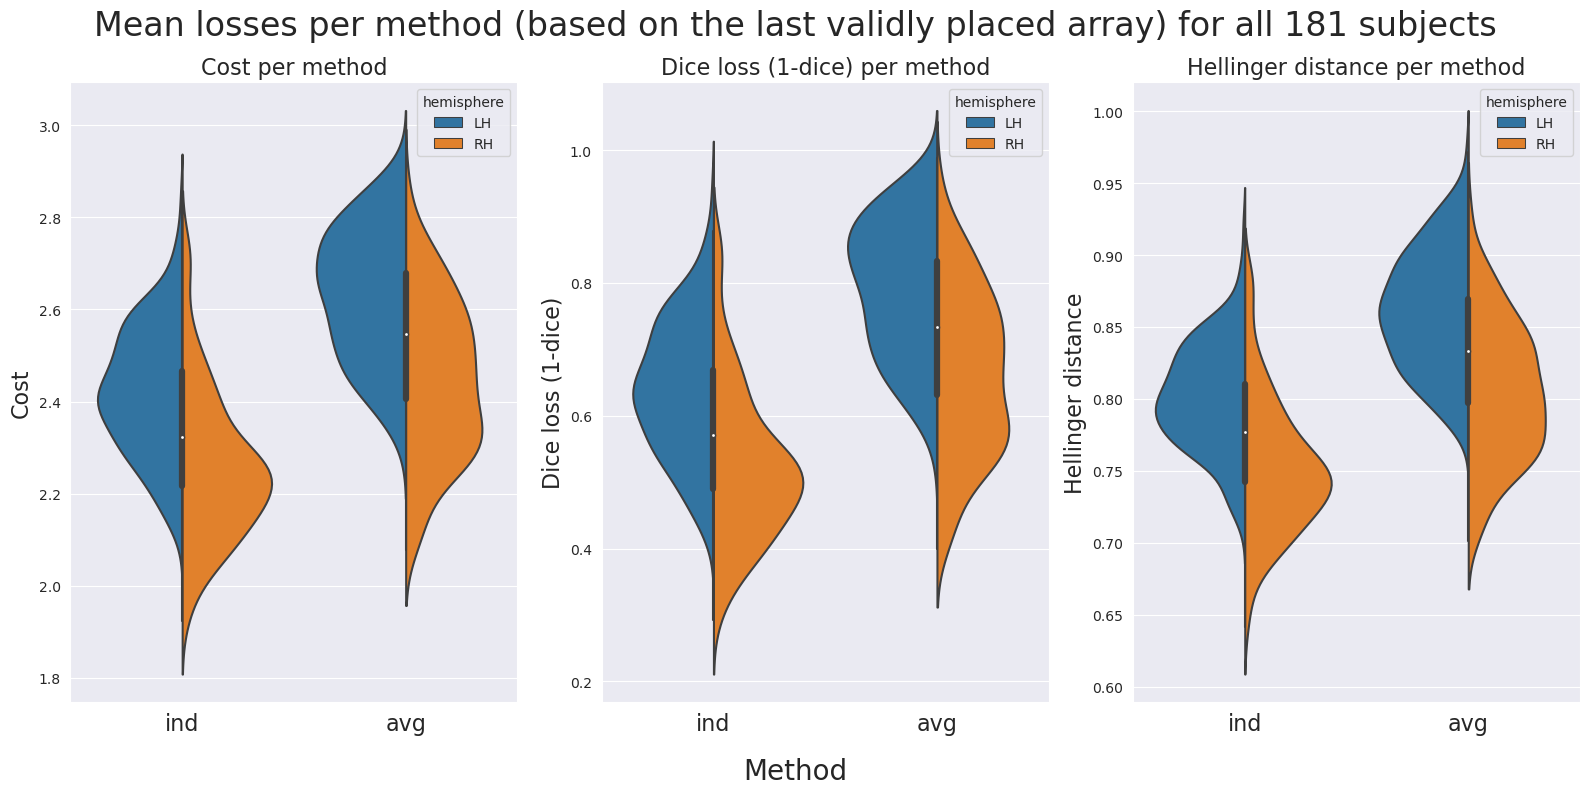

In [17]:
violin_plots_all(data)

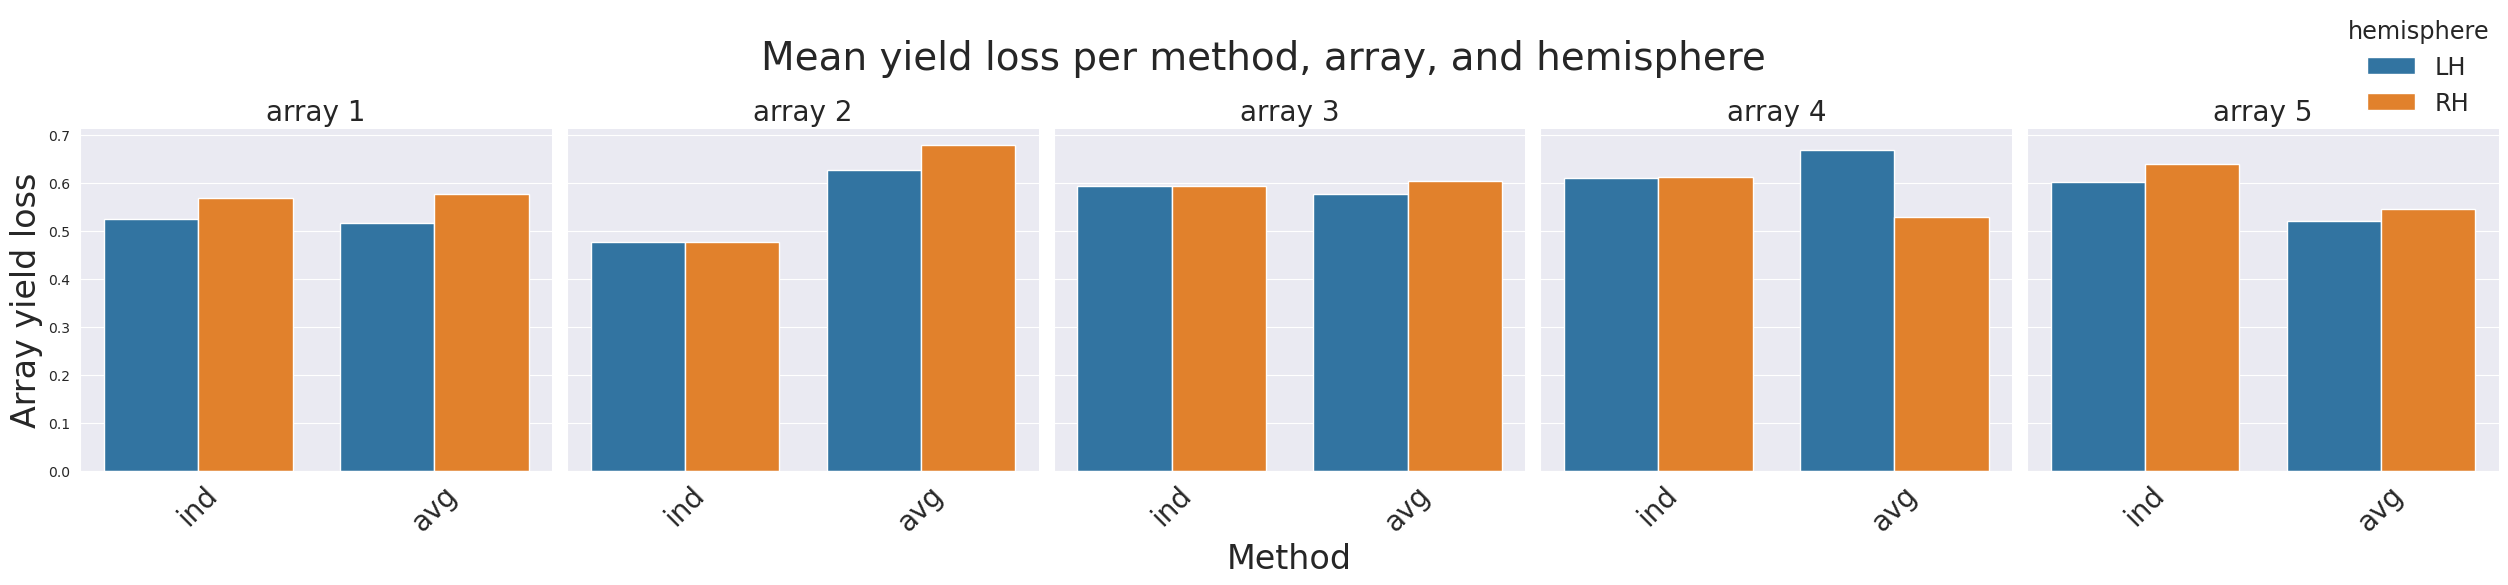

In [193]:
visualize_yield_loss(ind_descriptives, avg_descriptives)

In [11]:
get_mean_std(data)

data: ind_LH, mean: 2.423035588273815, std: 0.13934318431290058
data: avg_LH, mean: 2.6315107077464384, std: 0.14346917607168705
data: ind_RH, mean: 2.256895704216843, std: 0.16193447446226256
data: avg_RH, mean: 2.4439039401898333, std: 0.17121825884616845


In [25]:
run_paired_ttest(data, "cost")

TtestResult(statistic=-19.88626350196014, pvalue=1.3365138262947049e-47, df=180)
TtestResult(statistic=-18.93228371824435, pvalue=5.4030163362874495e-45, df=180)


In [13]:
total_subs = len(data.subject.unique())
stats = data.groupby(["hemisphere", "method"])[["max_array", "total_dice", "prop_total_dice", "array_yield", "total_HD", "prop_total_hd", "cost", "prop_cost"]].mean().reset_index()
stats["total_subjects"] = total_subs
stats["total_dice_loss"] = 1 - stats["total_dice"]
stats["array_yield_loss"] = 1 - stats["array_yield"]
column_order = ["method", "hemisphere", "max_array", "total_subjects",  "total_dice_loss", "prop_total_dice", "array_yield_loss", "total_HD", "prop_total_hd", "cost", "prop_cost"]
stats = stats[column_order]

In [14]:
round(stats, 2)

,method,hemisphere,max_array,total_subjects,total_dice_loss,prop_total_dice,array_yield_loss,total_HD,prop_total_hd,cost,prop_cost
0,avg,LH,3.40,181,0.79,0.28,0.57,0.86,0.45,2.63,0.23
1,ind,LH,4.55,181,0.64,0.48,0.61,0.80,0.64,2.42,0.37
2,avg,RH,3.27,181,0.66,0.42,0.57,0.80,0.54,2.44,0.36
3,ind,RH,4.52,181,0.52,0.59,0.63,0.75,0.68,2.26,0.48


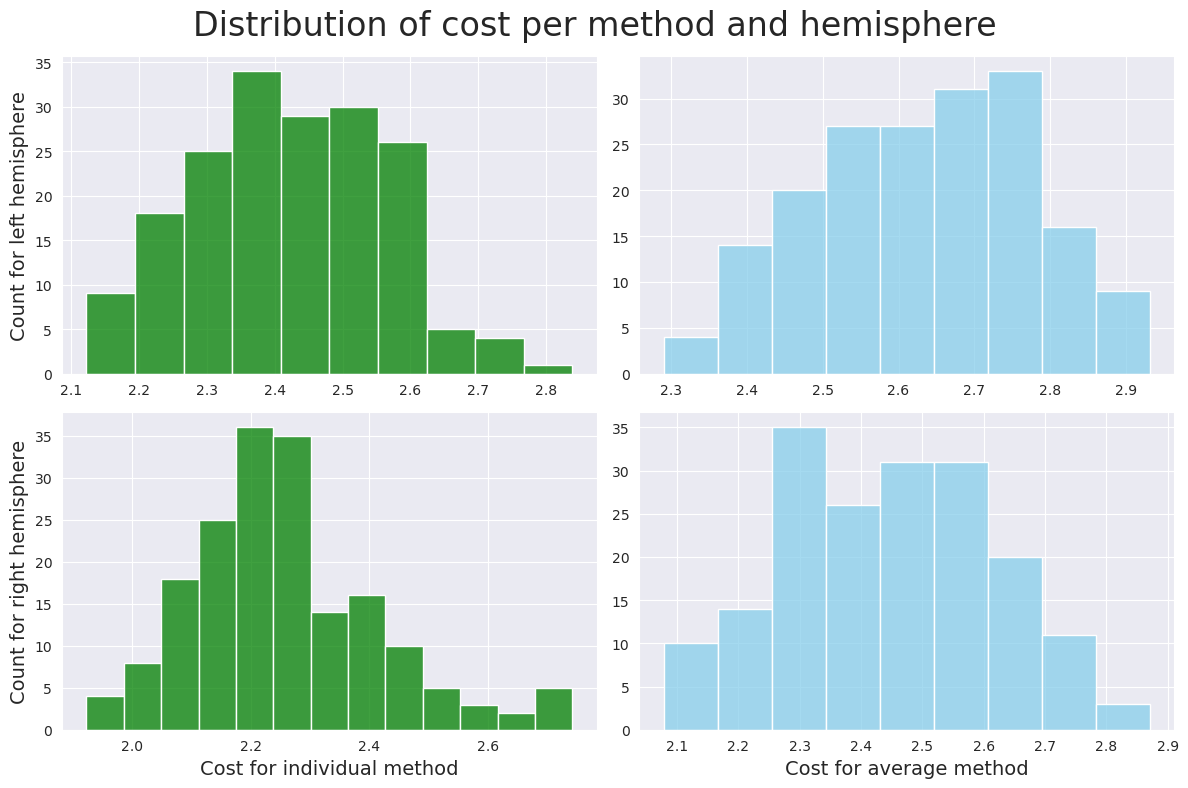

In [22]:
create_histograms(data)